# Task 3 Classification 

#### Group: B (Joseph Weibel / Rebecka Fahrni)

In [51]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from skmultilearn.model_selection import IterativeStratification
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.svm import SVC
import torch.nn as nn
import torch.nn.functional as F
from transformers.utils import logging
import wandb
import os

In [2]:
data = load_dataset('argilla/medical-domain')['train']
df = data.to_pandas()

# add label and text length
df['labels'] = df.prediction.apply(lambda x: x[0]['label'])
df = df.set_index('text')
df.shape


(4966, 13)

In [3]:
df_ohe = pd.get_dummies(df['labels'])
df_ohe = df_ohe.groupby(df_ohe.index).sum()
df_ohe.shape

(2357, 40)

In [6]:
df_duplicate_labels = (df_ohe > 1).sum(axis=1)
df_duplicate_labels = df_duplicate_labels[df_duplicate_labels > 0]
print(f'There are {len(df_duplicate_labels)} duplicate labels.')

There are 0 duplicate labels.


In [7]:
df_ohe = df_ohe.clip(upper=1)

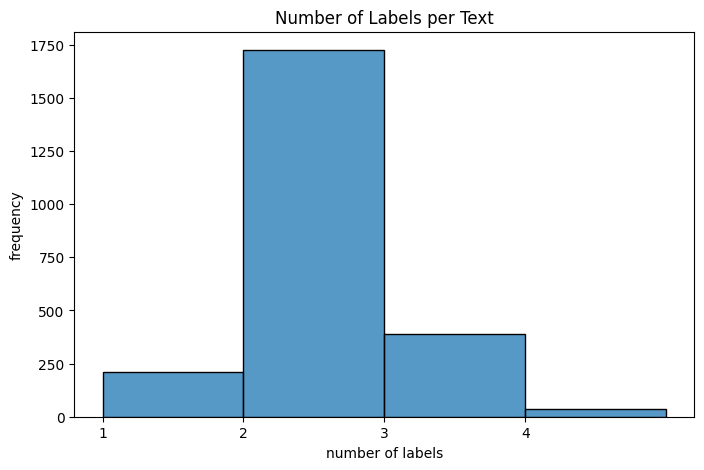

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(df_ohe.sum(axis=1), binwidth=1)
plt.title('Number of Labels per Text')
plt.xlabel('number of labels')
plt.ylabel('frequency')
plt.xticks([1, 2, 3, 4])
plt.show()

In [9]:
df_ohe = df_ohe.drop(columns=df_ohe.columns[df_ohe.sum(axis=0) < 25])
df_ohe.shape

(2357, 26)

In [10]:
df_ohe.sum(axis=0)

 Cardiovascular / Pulmonary        371
 Consult - History and Phy.        516
 Cosmetic / Plastic Surgery         27
 Dentistry                          27
 Dermatology                        29
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Emergency Room Reports             75
 Gastroenterology                  224
 General Medicine                  259
 Hematology - Oncology              90
 Nephrology                         81
 Neurology                         223
 Neurosurgery                       94
 Obstetrics / Gynecology           155
 Office Notes                       50
 Ophthalmology                      83
 Orthopedic                        355
 Pain Management                    59
 Pediatrics - Neonatal              70
 Podiatry                           47
 Psychiatry / Psychology            53
 Radiology                         273
 SOAP / Chart / Progress Notes     166
 Surgery                          1088
 Urology                 

## Evaluation

In [11]:
n_splits = 5

if not os.path.exists('./data/fold_0_train.csv'):
	k_fold = IterativeStratification(n_splits=n_splits, order=1)
	for idx, (train_idx, test_idx) in enumerate(k_fold.split(df_ohe.index, df_ohe.values)):
		train, test = df_ohe.iloc[train_idx], df_ohe.iloc[test_idx]

		train.to_csv(f'./data/fold_{idx}_train.csv')
		test.to_csv(f'./data/fold_{idx}_test.csv')


In [12]:
splits = []
for idx in range(n_splits):
	train = pd.read_csv(f'./data/fold_{idx}_train.csv', index_col=0)
	test = pd.read_csv(f'./data/fold_{idx}_test.csv', index_col=0)
	splits.append((train.index, test.index, train.values, test.values))

print(len(splits))

5


## Baseline

In [48]:
# sw = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# texts = df_ohe.index.str.lower()
# texts = [word_tokenize(text) for text in texts]
# texts = [[lemmatizer.lemmatize(word) for word in text if word not in sw] for text in texts]
# texts = [[text for word in text if re.match('[a-z]', word)] for text in texts]
# texts

In [15]:
# lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

p_scores_baseline = np.zeros((n_splits, df_ohe.shape[1]))
r_scores_baseline = np.zeros((n_splits, df_ohe.shape[1]))
f1_scores_baseline = np.zeros((n_splits, df_ohe.shape[1]))
for idx, (X_train, X_test, Y_train, Y_test) in enumerate(splits):
	vectorizer = TfidfVectorizer(
		min_df=3,
		max_df=0.5,
		lowercase=True,
		preprocessor=stemmer.stem,
		stop_words=[stemmer.stem(word) for word in stopwords.words('english')]
	)
	X_train_transformed = vectorizer.fit_transform(X_train)
	X_test_transformed = vectorizer.transform(X_test)

	sample_weights = compute_sample_weight('balanced', Y_train)

	# model = MultiOutputClassifier(MultinomialNB())
	model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1))
	# model = MultiOutputClassifier(SVC(kernel='linear', probability=True))
	model.fit(X_train_transformed, Y_train)
	Y_pred = model.predict(X_test_transformed)

	p_scores_baseline[idx], r_scores_baseline[idx], f1_scores_baseline[idx], _ = precision_recall_fscore_support(Y_test, Y_pred, average=None)


/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-d

In [19]:
def plot_f1_scores(f1_scores, name):
	f1_scores_df = pd.DataFrame(f1_scores.T, index=df_ohe.columns)
	f1_scores_df = f1_scores_df.melt(var_name='iteration', value_name='score', ignore_index=False)
	f1_scores_df = f1_scores_df.reset_index(names='label')
	f1_scores_df = f1_scores_df.sort_values(by='score', ascending=False)

	plt.figure(figsize=(8, 7))
	sns.barplot(f1_scores_df, x='score', y='label')
	plt.title(f'F1-Scores for {name} Model')
	plt.xlabel('f1 score')
	plt.ylabel('label')
	plt.show()

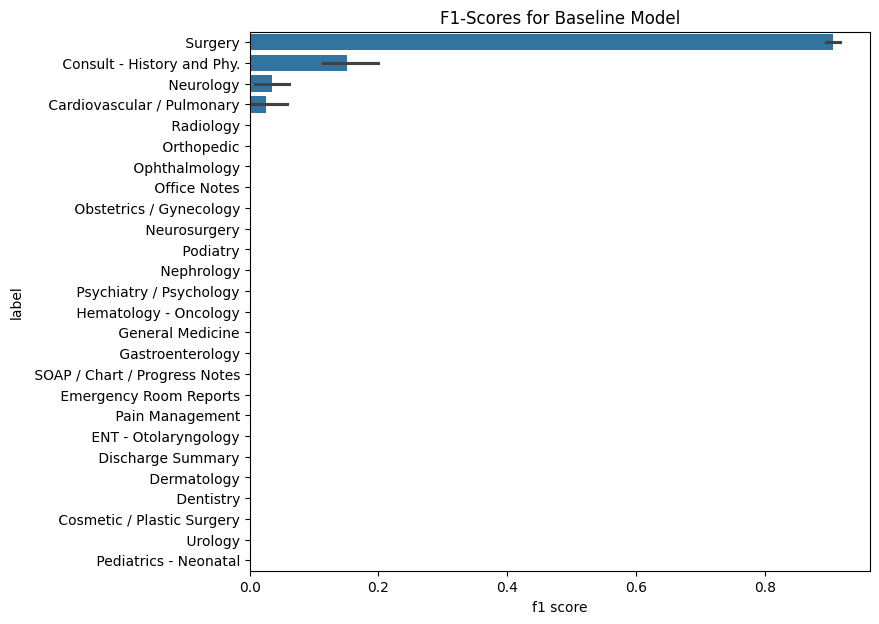

In [20]:
plot_f1_scores(f1_scores_baseline, 'Baseline')

## BERT

In [52]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.texts.items()}
        item['labels'] = self.labels[idx]
        return item

In [68]:
class Classifier(nn.Module):
	def __init__(self, base_model_name, n_classes, class_weights=None) -> None:
		super().__init__()
		self.model = AutoModel.from_pretrained(base_model_name)
		self.linear = nn.Linear(768, n_classes)

		self.class_weights = torch.Tensor(class_weights.values) if class_weights is not None else None

	def forward(self, input_ids, attention_mask, labels=None, **kwargs):
		x = self.model(input_ids, attention_mask, **kwargs)
		x = x.last_hidden_state[:, 0, :]
		x = self.linear(x)

		weights = None
		if self.class_weights is not None:
			self.class_weights = self.class_weights.to(labels.device)
			weights = self.class_weights.repeat(len(labels), 1)

		return SequenceClassifierOutput(
			loss=F.binary_cross_entropy_with_logits(x, labels, weights),
			logits=F.sigmoid(x)
		)

In [69]:
def compute_metrics(eval_pred):
	Y_pred, Y_test = eval_pred
	Y_pred = (Y_pred > 0.5).astype(int)
	p, r, f, _ = precision_recall_fscore_support(Y_test, Y_pred, average=None)

	p_series = pd.Series(p)
	p_series.index = 'p_' + p_series.index.astype(str)
	r_series = pd.Series(r)
	r_series.index = 'r_' + r_series.index.astype(str)
	f1_series = pd.Series(f)
	f1_series.index = 'f1_' + f1_series.index.astype(str)

	return {**p_series.to_dict(), **r_series.to_dict(), **f1_series.to_dict()}

def train_bert_models(model_name, weighted_loss=False):
	scores_filepath = f'./models/{model_name}_scores.npy'
	if os.path.exists(scores_filepath):
		scores = np.load(scores_filepath)
		return scores[0], scores[1], scores[2]

	logging.set_verbosity_warning()

	tokenizer = AutoTokenizer.from_pretrained(model_name)

	class_weights = 1 / df_ohe.sum(axis=0) if weighted_loss else None

	p_scores = np.zeros((n_splits, df_ohe.shape[1]))
	r_scores = np.zeros((n_splits, df_ohe.shape[1]))
	f1_scores = np.zeros((n_splits, df_ohe.shape[1]))
	for i, (X_train, X_test, Y_train, Y_test) in enumerate(splits):
		output_path = f'./models/{model_name}/it_{i}'
		model = Classifier(model_name, df_ohe.shape[1], class_weights)

		Y_train, Y_test = Y_train.astype('float32'), Y_test.astype('float32')
		X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, max_length=256)
		X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, max_length=256)

		training_args = TrainingArguments(
			output_dir=output_path,
			num_train_epochs=10,
			do_train=True,
			per_device_train_batch_size=32,
			learning_rate=1e-04,
			weight_decay=0.1,
			push_to_hub=False,
			logging_steps=10,
			save_total_limit=1,
			save_steps=100,
		)

		trainer = Trainer(
			model=model,
			args=training_args,
			train_dataset=Dataset(X_train_tokens, Y_train),
			tokenizer=tokenizer,
			compute_metrics=compute_metrics
		)

		trainer.train()

		prediction = trainer.predict(Dataset(X_test_tokens, Y_test), metric_key_prefix='test')
		metrics = pd.Series(prediction.metrics)

		p_metrics = metrics[metrics.index.str.startswith('test_p_')]
		p_metrics.index = p_metrics.index.str.replace('test_p_', '').astype(int)
		p_scores[i] = p_metrics.values

		r_metrics = metrics[metrics.index.str.startswith('test_r_')]
		r_metrics.index = r_metrics.index.str.replace('test_r_', '').astype(int)
		r_scores[i] = r_metrics.values

		f1_metrics = metrics[metrics.index.str.startswith('test_f1_')]
		f1_metrics.index = f1_metrics.index.str.replace('test_f1_', '').astype(int)
		f1_scores[i] = f1_metrics.values

		wandb.finish()

	scores = np.stack((p_scores, r_scores, f1_scores), axis=0)
	np.save(scores_filepath, scores)

	return p_scores, r_scores, f1_scores

In [62]:
p_scores_bert, r_scores_bert, f1_scores_bert = train_bert_models('bert-base-uncased', weighted_loss=True)

In [63]:
p_scores_biobert, r_scores_biobert, f1_scores_biobert = train_bert_models('dmis-lab/biobert-base-cased-v1.2')

In [70]:
p_scores_clinicalbert, r_scores_clinicalbert, f1_scores_clinicalbert = train_bert_models('medicalai/ClinicalBERT')

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                       
  0%|          | 0/590 [01:56<?, ?it/s]         

{'loss': 0.4286, 'learning_rate': 9.830508474576272e-05, 'epoch': 0.17}


                                       
  0%|          | 0/590 [02:06<?, ?it/s]         

{'loss': 0.2527, 'learning_rate': 9.661016949152543e-05, 'epoch': 0.34}


                                       
  0%|          | 0/590 [02:15<?, ?it/s]         

{'loss': 0.222, 'learning_rate': 9.491525423728815e-05, 'epoch': 0.51}


                                       
  0%|          | 0/590 [02:25<?, ?it/s]         

{'loss': 0.2126, 'learning_rate': 9.322033898305085e-05, 'epoch': 0.68}


                                       
  0%|          | 0/590 [02:34<?, ?it/s]         

{'loss': 0.204, 'learning_rate': 9.152542372881357e-05, 'epoch': 0.85}


                                       
  0%|          | 0/590 [02:43<?, ?it/s]         

{'loss': 0.189, 'learning_rate': 8.983050847457629e-05, 'epoch': 1.02}


                                       
  0%|          | 0/590 [02:53<?, ?it/s]         

{'loss': 0.1678, 'learning_rate': 8.813559322033899e-05, 'epoch': 1.19}


                                       
  0%|          | 0/590 [03:02<?, ?it/s]         

{'loss': 0.1632, 'learning_rate': 8.644067796610171e-05, 'epoch': 1.36}


                                       
  0%|          | 0/590 [03:12<?, ?it/s]         

{'loss': 0.1542, 'learning_rate': 8.474576271186441e-05, 'epoch': 1.53}


                                       
  0%|          | 0/590 [03:21<?, ?it/s]          

{'loss': 0.1384, 'learning_rate': 8.305084745762712e-05, 'epoch': 1.69}


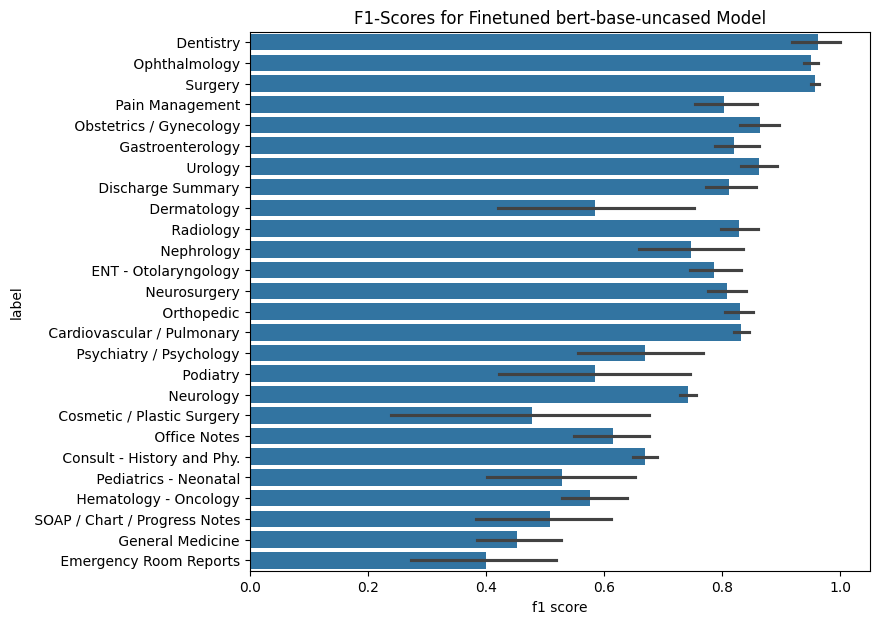

In [64]:
plot_f1_scores(f1_scores_bert, 'Finetuned bert-base-uncased')

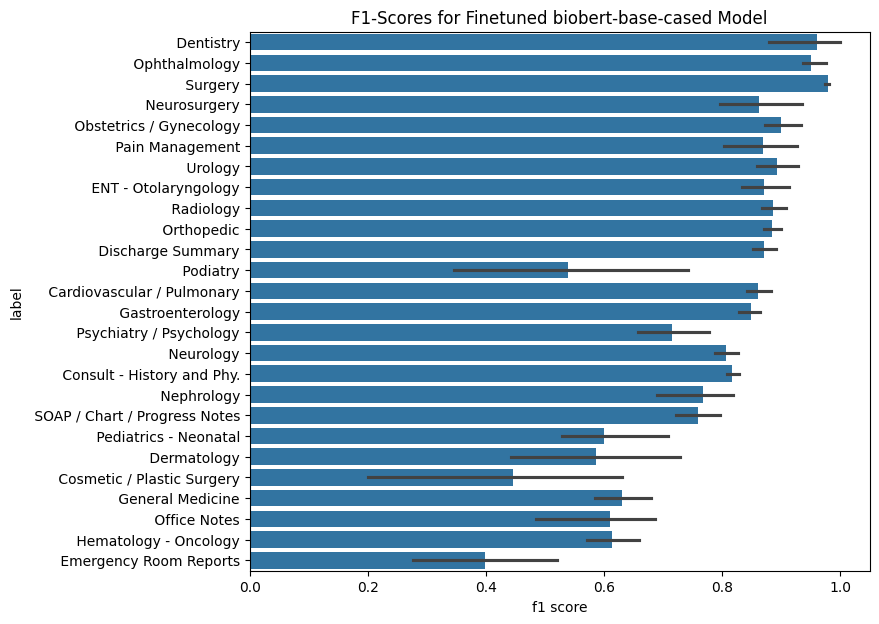

In [65]:
plot_f1_scores(f1_scores_biobert, 'Finetuned biobert-base-cased')

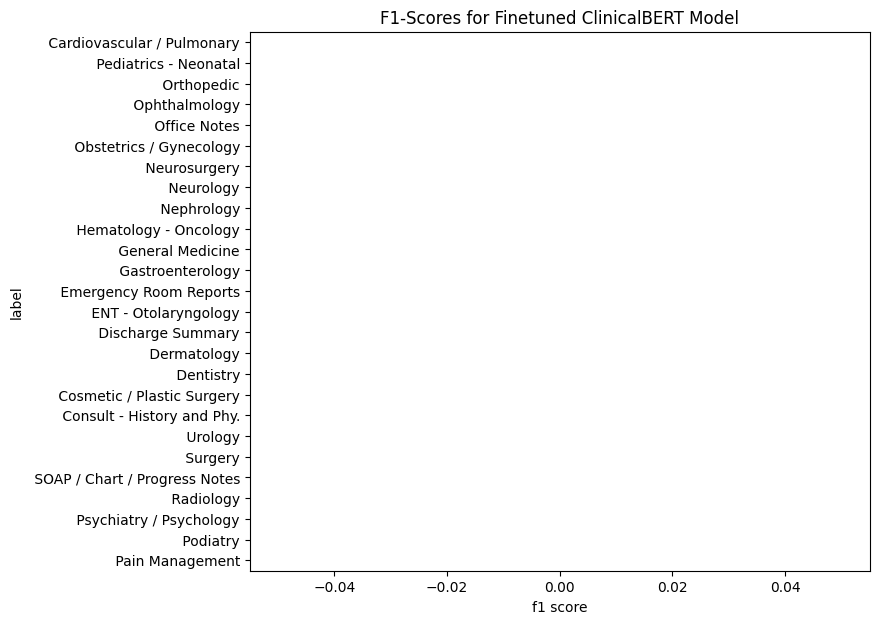

In [38]:
plot_f1_scores(f1_scores_clinicalbert, 'Finetuned ClinicalBERT')

## GPT

In [ ]:
template = """[INST] <<SYS>>

You are a helpful assistant responding to the user's classification requests. Answer in a single word: yes or no.

<</SYS>>

Do you think the following text can be classified as "{category}"? Answer yes or no.

{text}
[/INST]"""

prompts = []
for i, text in enumerate(df_ohe.index):
	for cat in df_ohe.columns:
		prompts.append({
			'index': i,
			'text': text,
			'cat': cat,
			'prompt': template.replace('{category}', cat.strip()).replace('{text}', text)
		})

pd.DataFrame(prompts).to_csv('./prompts/llama2-7b-v1.csv')

In [ ]:
template = """[INST] <<SYS>>

You are a helpful assistant responding to the user's classification requests. Answer in a single word: yes or no.

<</SYS>>

Do you think the following text can be classified as "{category}"? Answer yes or no.

{sample_text}
[/INST]
Yes.

[INST]
Do you think the following text can be classified as "{category}"? Answer yes or no.

{text}
[/INST]"""

prompts = []
for i, text in enumerate(df_ohe.index):
	for cat in df_ohe.columns:
		sample_text = df_ohe[df_ohe[cat] == 1].drop(index=text, errors='ignore').sample(1).index.values[0]

		prompts.append({
			'index': i,
			'text': text,
			'cat': cat,
			'prompt': template.replace('{category}', cat.strip()).replace('{text}', text).replace('{sample_text}', sample_text)
		})

pd.DataFrame(prompts).to_csv('./prompts/llama2-7b-v2.csv')

In [ ]:
template = """Answer in a single word: yes or no. Do you think the following text can be classified as "{category}"? Answer yes or no.

{text}

Answer: """

prompts = []
for i, text in enumerate(df_ohe.index):
	for cat in df_ohe.columns:
		prompts.append({
			'index': i,
			'text': text,
			'cat': cat,
			'prompt': template.replace('{category}', cat.strip()).replace('{text}', text)
		})

pd.DataFrame(prompts).to_csv('./prompts/meditron-7b-v1.csv')

In [ ]:
template = """You are a helpful assistant responding to the user's classification requests. Answer in a single word: yes or no.

### Instruction: Do you think the following text can be classified as "{category}"? Answer yes or no.

{text}

### Response: """

prompts = []
for i, text in enumerate(df_ohe.index):
	for cat in df_ohe.columns:
		prompts.append({
			'index': i,
			'text': text,
			'cat': cat,
			'prompt': template.replace('{category}', cat.strip()).replace('{text}', text)
		})

pd.DataFrame(prompts).to_csv('./prompts/meditron-7b-v4.csv')

In [ ]:
template = """[INST]Do you think the following text can be classified as "{category}"? Answer in a single word: yes or no.

{text} [/INST]"""

prompts = []
for i, text in enumerate(df_ohe.index):
	for cat in df_ohe.columns:
		prompts.append({
			'index': i,
			'text': text,
			'cat': cat,
			'prompt': template.replace('{category}', cat.strip()).replace('{text}', text)
		})

pd.DataFrame(prompts).to_csv('./prompts/mistral-7b-v1.csv')

### Results

In [42]:
def postprocess_answers(results):
	results['answer'] = results['answer'].str.replace('\.$', '', regex=True)
	print(results['answer'].value_counts())
	print()

	tokens = results['answer'].str.lower().str.split(expand=True).stack().reset_index(level=1, drop=True).reset_index(name='token')
	tokens['yes'] = tokens['token'] == 'yes'
	tokens['no'] = tokens['token'] == 'no'

	tokens = tokens.groupby('index').sum(numeric_only=True).astype(int)

	result = tokens.idxmax(axis='columns').rename('pred')

	# tiebreaking
	result[tokens['yes'] == tokens['no']] = np.nan

	results['pred'] = result.map({'yes': 1, 'no': 0})

	print(result.value_counts(dropna=False))


In [43]:
results7b = pd.read_csv('./prompts/llama2-7b-v1.csv', index_col=0)
results7b['model'] = 'Llama 2 (7B)'
results13b = pd.read_csv('./prompts/llama2-13b-v1.csv', index_col=0)
results13b['model'] = 'Llama 2 (13B)'

print('Llama 2 (7B)')
postprocess_answers(results7b)

print()
print()
print('Llama 2 (13B)')
postprocess_answers(results13b)

Llama 2 (7B)
answer
  Yes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [44]:
pred7b = results7b.pivot(index='text', columns='cat', values='pred')
pred13b = results13b.pivot(index='text', columns='cat', values='pred')
pred13b.shape, pred7b.shape

((2357, 26), (2357, 26))

In [45]:
p_7b, r_7b, f1_scores_7b, support = precision_recall_fscore_support(df_ohe, pred7b.fillna(0), average=None)
p_13b, r_13b, f1_scores_13b, _ = precision_recall_fscore_support(df_ohe, pred13b.fillna(0), average=None)

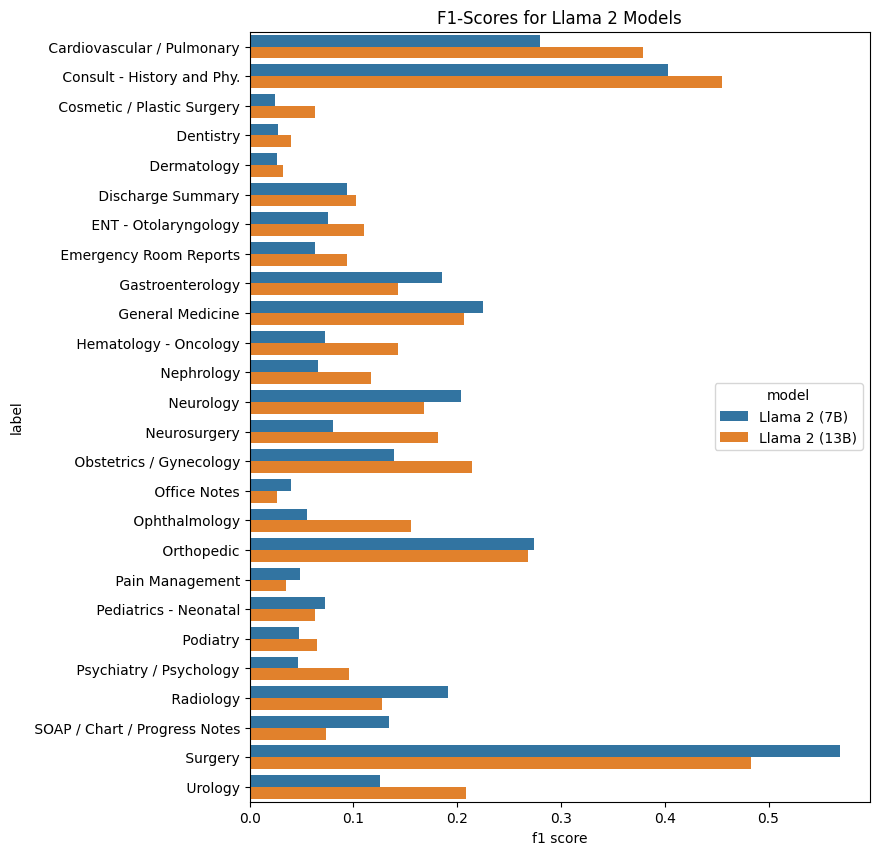

In [46]:
f1_scores_7b_df = pd.Series(f1_scores_7b, index=df_ohe.columns)
f1_scores_7b_df = f1_scores_7b_df.rename('score').to_frame().reset_index(names='label')
f1_scores_7b_df['model'] = 'Llama 2 (7B)'

f1_scores_13b_df = pd.Series(f1_scores_13b, index=df_ohe.columns)
f1_scores_13b_df = f1_scores_13b_df.rename('score').to_frame().reset_index(names='label')
f1_scores_13b_df['model'] = 'Llama 2 (13B)'

f1_scores_df = pd.concat((f1_scores_7b_df, f1_scores_13b_df))

plt.figure(figsize=(8, 10))
sns.barplot(f1_scores_df, x='score', y='label', hue='model')
plt.title('F1-Scores for Llama 2 Models')
plt.xlabel('f1 score')
plt.ylabel('label')
plt.show()

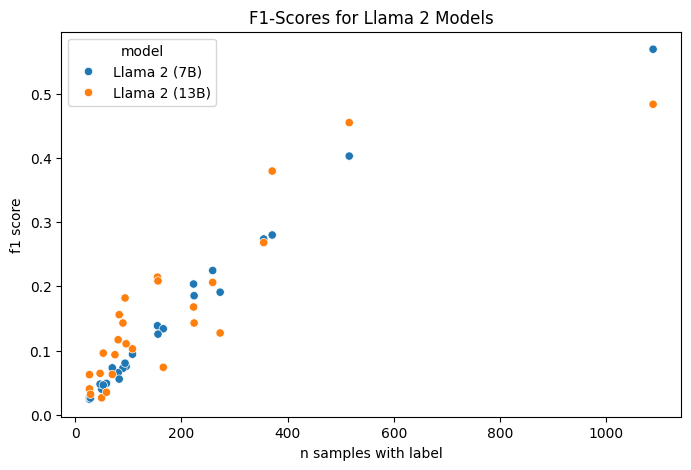

In [47]:
support_df = pd.Series(support, index=df_ohe.columns)
support_df = support_df.rename('support').to_frame().reset_index(names='label')

f1_support_scores_df = f1_scores_df.set_index('label')
f1_support_scores_df['support'] = pd.Series(support, index=df_ohe.columns)

plt.figure(figsize=(8, 5))
sns.scatterplot(f1_support_scores_df, x='support', y='score', hue='model')
plt.title('F1-Scores for Llama 2 Models')
plt.xlabel('n samples with label')
plt.ylabel('f1 score')
plt.show()

## Conclusion

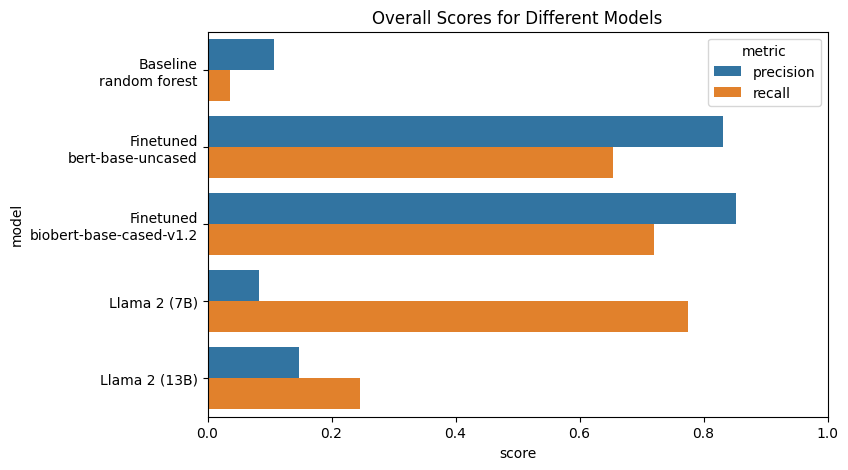

In [50]:
scores_df = pd.DataFrame([
	{'model': 'Baseline\nrandom forest', 'metric': 'precision', 'score': p_scores_baseline.mean()},
	{'model': 'Baseline\nrandom forest', 'metric': 'recall', 'score': r_scores_baseline.mean()},
	{'model': 'Finetuned\nbert-base-uncased', 'metric': 'precision', 'score': p_scores_bert.mean()},
	{'model': 'Finetuned\nbert-base-uncased', 'metric': 'recall', 'score': r_scores_bert.mean()},
	{'model': 'Finetuned\nbiobert-base-cased-v1.2', 'metric': 'precision', 'score': p_scores_biobert.mean()},
	{'model': 'Finetuned\nbiobert-base-cased-v1.2', 'metric': 'recall', 'score': r_scores_biobert.mean()},
	{'model': 'Llama 2 (7B)', 'metric': 'precision', 'score': p_7b.mean()},
	{'model': 'Llama 2 (7B)', 'metric': 'recall', 'score': r_7b.mean()},
	{'model': 'Llama 2 (13B)', 'metric': 'precision', 'score': p_13b.mean()},
	{'model': 'Llama 2 (13B)', 'metric': 'recall', 'score': r_13b.mean()}
])

plt.figure(figsize=(8, 5))
sns.barplot(scores_df, x='score', y='model', hue='metric')
plt.title('Overall Scores for Different Models')
plt.xlabel('score (macro averaged)')
plt.xlim(0, 1)
plt.show()

Todo:
- Texte abschneiden (512 Tokens)
- Baseline mit TFIDF und NB/SVM
 - Preprocessing Pipeline: Snowball, lowercasing, lemmatization, Satzzeichen entfernen, Zahlen entfernen
- BERT
 - kein Preprocessing
 - bert-base-uncased, biobert, ...
- GPT
 - llama2, meditron
 - pro Label und alle Label gleichzeitig abfragen
- Evaluierung
 - 3-fach cross-validation 
 - f1-scores (pro Label und insgesamt)
- Preprocessing
 - alle Label mit weniger als 20 Texten entfernen
 - Oversampling